In [1]:
#!pip install tensorflow keras

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import tensorflow as tf
import os 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

2023-04-04 18:13:26.017611: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 18:13:28.070383: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-04 18:13:28.070449: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-04 18:13:28.070453: W tensorfl

# Summary:
##### The create_dataset function is used to create a dataset suitable for training time series models. 
##### It takes two arguments: dataset, which is a 2D NumPy array containing the time series data, and look_back
##### integer specifying the number of previous time steps to include in the input data (default is 1).
##
##### The function loops through the dataset, creating input-target pairs. For each input (X), it takes a sequence of look_back ##### data points, 
##### and the target (Y) is the data point immediately following the sequence. The input and target data are stored in separate ##### lists, which are 
##### then converted to NumPy arrays and returned.

In [3]:
def create_dataset(dataset, look_back=1):
    #Sotre input and target Data 
    data_x, data_y = [], []
    
    # Loop through the dataset, leaving out the last 'look_back' data points
    for i in range(len(dataset) - look_back):
        data_x.append(dataset[i:(i + look_back), 0])
        data_y.append(dataset[i + look_back, 0])
        
    # Convert the lists of input and target data to NumPy arrays
    return np.array(data_x), np.array(data_y)


# Summary:
##### The load_and_preprocess_data function is used to load and preprocess time series data from an Excel file.
##### It takes one argument, file_name, which is the name of the Excel file containing the data.
####
##### The function reads the data into a pandas DataFrame, then aggregates it by taking the mean of the columns 'INF_ALL', 
##### 'INF_A', and 'INF_B' for each date. The 'ISO_SDATE' column is extracted, cleaned, and set as the index of the DataFrame.
####
##### Outliers in the 'INF_ALL' column are removed using the Interquartile Range (IQR) method.
##### Finally, the preprocessed 'INF_ALL' column is returned as a pandas Series.

In [4]:
def load_and_preprocess_data(file_name):
    # Load data from the given file into a pandas DataFrame
    df = pd.read_excel(file_name, engine='openpyxl')
    df_agg = df.groupby(['ISO_YEAR', 'ISO_SDATE']).agg({'INF_ALL': 'sum', 'INF_A': 'sum', 'INF_B': 'sum'}).reset_index()
    df_agg['ISO_SDATE'] = df_agg['ISO_SDATE'].str.split('T').str[0]
    df_agg['ISO_SDATE'] = pd.to_datetime(df_agg['ISO_SDATE'])
    
    # Set the 'ISO_SDATE' column as the index of the DataFrame
    df_agg.set_index('ISO_SDATE', inplace=True)

    #Remove outliers using IQR method
    Q1 = df_agg['INF_ALL'].quantile(0.25)
    Q3 = df_agg['INF_ALL'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_agg = df_agg[(df_agg['INF_ALL'] > lower_bound) & (df_agg['INF_ALL'] < upper_bound)]

    return df_agg['INF_ALL']

# Summary 
##### This function trains a Long Short-Term Memory (LSTM) model to predict influenza cases. It takes in the data, look_back, 
##### epochs, and batch_size as inputs. The function first reshapes and  normalizes the data before 
##### splitting it into training and testing sets. The LSTM model is built and trained using the provided parameters.
##### The function returns the trained model, the scaler, and the predictions for both the training and testing sets.

In [5]:
def train_lstm_model(data, look_back, epochs, batch_size):
    # Reshape and normalize the data
    data = np.array(data).reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    # Split the dataset into train and test sets
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]

    # Create the datasets with the specified look_back
    train_x, train_y = create_dataset(train, look_back)
    test_x, test_y = create_dataset(test, look_back)

    # Reshape the input to be [samples, time steps, features]
    train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
    test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(100, input_shape=(1, look_back)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_x, test_y),
              callbacks=[early_stopping], verbose=0) # Set verbose to 1 to see validation error.

    # Make predictions
    train_predict = model.predict(train_x)
    test_predict = model.predict(test_x)

    # Invert predictions and target values to their original scale
    train_predict = scaler.inverse_transform(train_predict)
    train_y = scaler.inverse_transform(train_y.reshape(-1, 1))
    test_predict = scaler.inverse_transform(test_predict)
    test_y = scaler.inverse_transform(test_y.reshape(-1, 1))

    return model, scaler, train_predict, test_predict, train_y, test_y

# Summary: 
##### This function visualizes the original data and the forecasts made by the LSTM model for both the training and testing sets. It takes in the data, train_predict, test_predict, 
##### and look_back as inputs. The function creates a plot displaying the original data, training predictions, and testing predictions, with appropriate labels, axis titles, and a legend.


In [6]:
def visualize_data_and_forecast(data, train_predict, test_predict, look_back):
    plt.figure(figsize=(12, 6))
    plt.plot(data, label='Original Data')
    plt.plot(data.index[look_back:len(train_predict) + look_back], train_predict, label='Train Predictions')
    plt.plot(data.index[len(train_predict) + 2*look_back:], test_predict.flatten(), label='Test Predictions')
    plt.xlabel('Weeks')
    plt.ylabel('Influenza Cases')
    plt.title('Influenza Cases Forecast with LSTM')
    plt.legend()
    plt.show()


# Plotting the original Data

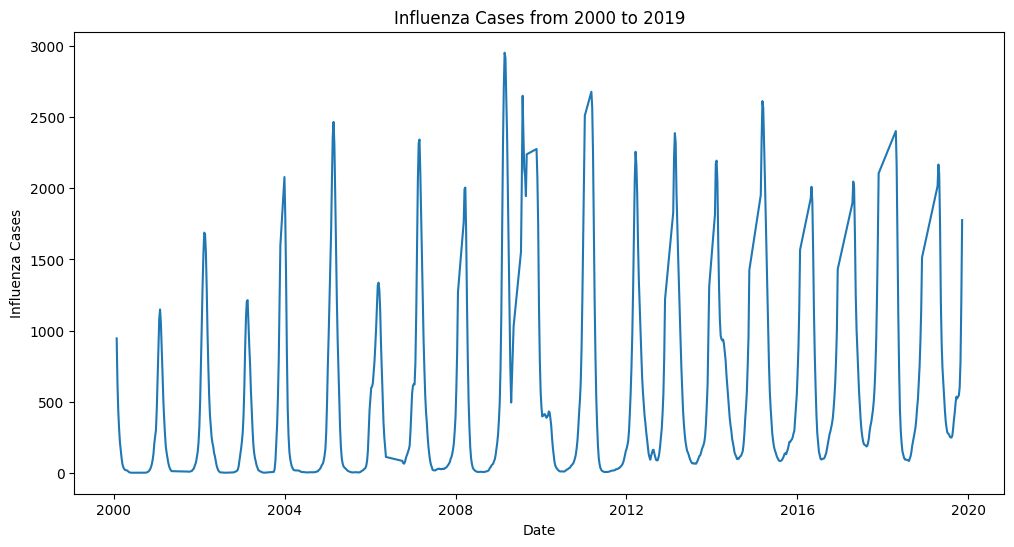

In [7]:
file_name = 'US_2000-2019_influenza_Data.xlsx'
data = load_and_preprocess_data(file_name)

data = data.rolling(window=4).mean().dropna()
# Plot the data and seasonal decomposition
plt.figure(figsize=(12, 6))
plt.plot(data)
plt.xlabel('Date')
plt.ylabel('Influenza Cases')
plt.title('Influenza Cases from 2000 to 2019')
plt.show()

# Summary:
##### This code seasonal decomposition of the given time series.   
##### The seasonal decomposition breaks the time series data into its trend, seasonality, and residual components. 

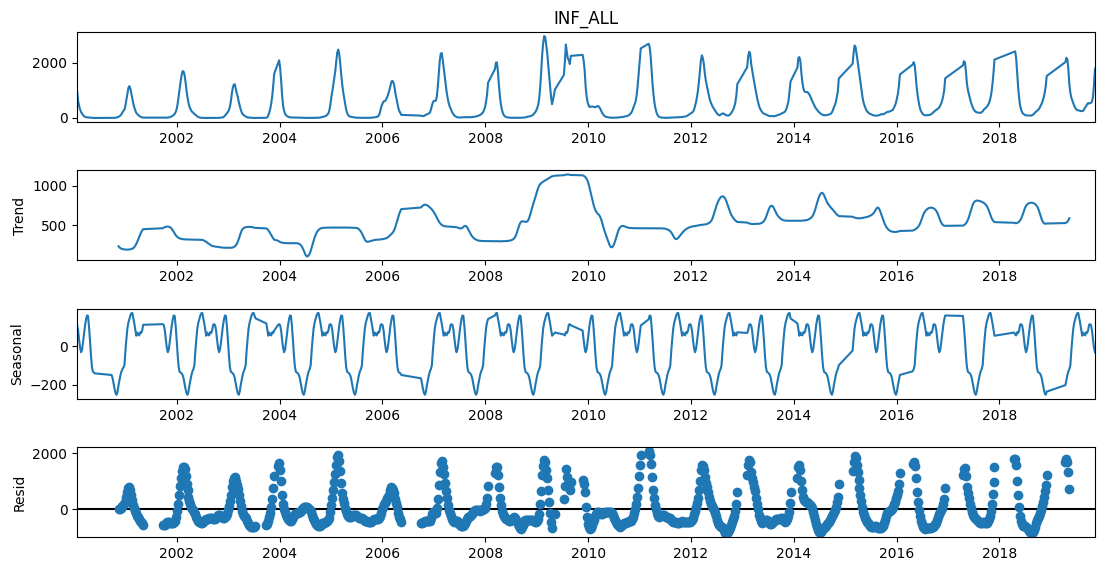

In [8]:
decomposition = seasonal_decompose(data, period=52)
fig = decomposition.plot()
fig.set_size_inches(12, 6)
plt.show()

# Summary:
##### This code first defines several parameters for training the LSTM model, such as the look_back, epochs, and batch_size. 
##### It then calls the train_lstm_model() function with the data and these parameters, which returns the trained LSTM model,
##### the scaler object, and the predicted values for both the training and testing sets.

##### After that, the visualize_data_and_forecast() function is called with the original data, training predictions, testing predictions, 
##### and the look_back value. This function creates a plot that visualizes the original data along with the predictions made by the LSTM 
##### model for the training and testing sets.

4/4 [==============================] - 0s 2ms/step


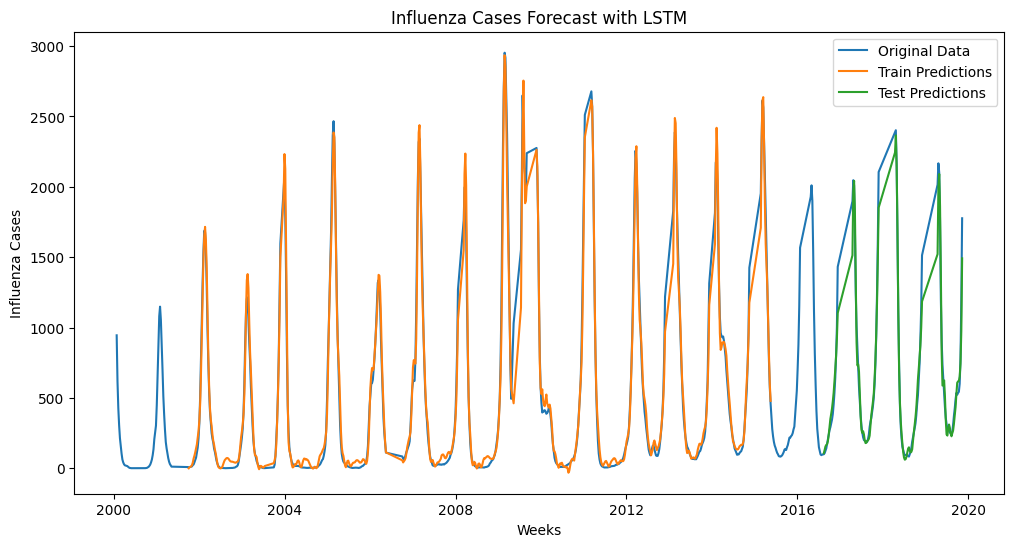

In [9]:
# Train the LSTM model
look_back = 52
epochs = 150
batch_size = 64
lstm_model, scaler, train_predict, test_predict, train_y, test_y = train_lstm_model(
    data, look_back, epochs, batch_size
)
# Visualize the data and forecast
visualize_data_and_forecast(data, train_predict, test_predict, look_back)

# Summary: 
#### This code defines the predict_future() function, which takes an LSTM model, a scaler object, the original data, a look_back value, 
#### and the number of weeks for which predictions are to be made. 
#### The function generates future predictions by iteratively feeding the model with the previous predictions as input.

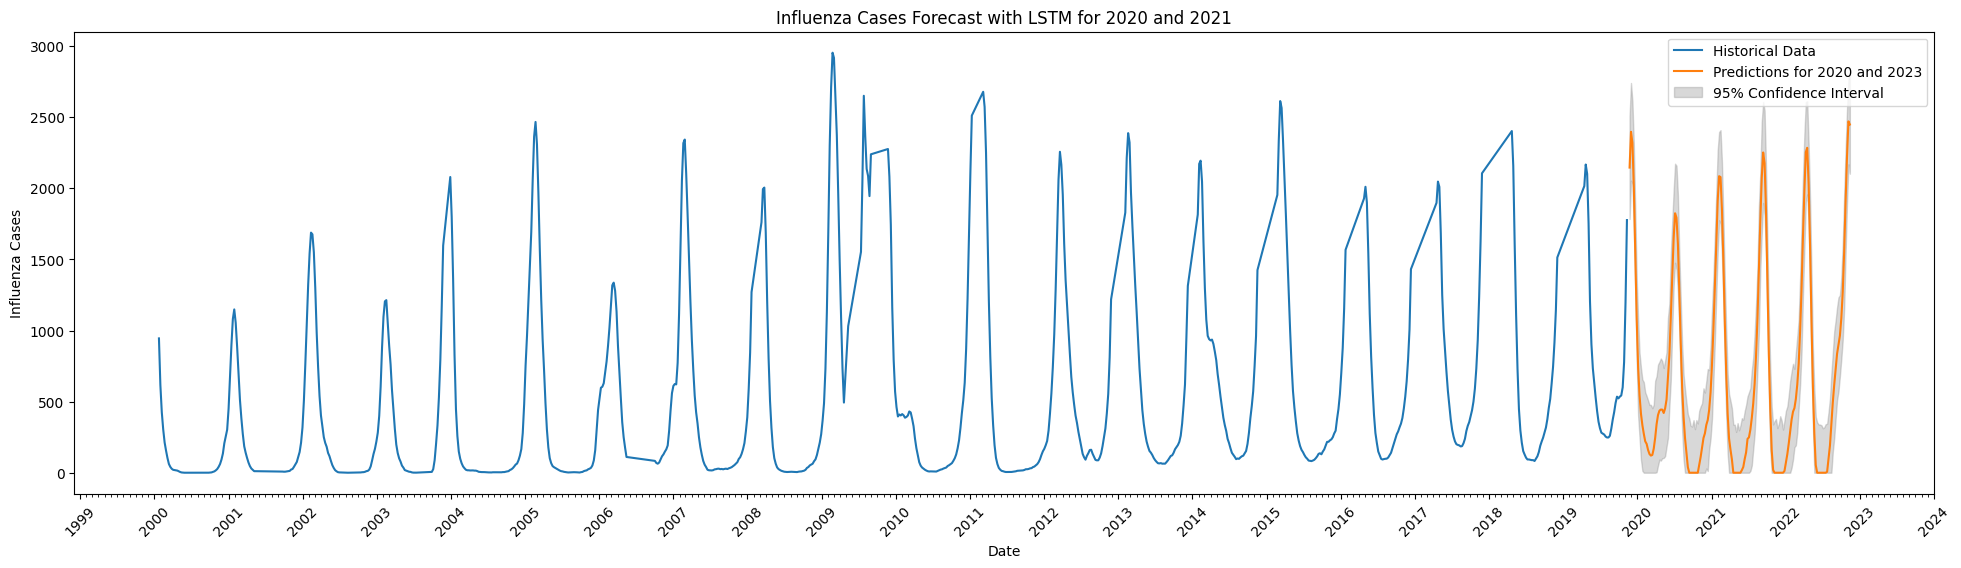

In [ ]:
def predict_future(model, scaler, data, look_back, num_weeks, num_simulations=100, noise_std=0.05):
    future_predictions = []
    input_data = data[-look_back:]

    for _ in range(num_weeks):
        input_data_scaled = scaler.transform(np.array(input_data).reshape(-1, 1))
        
        # Run multiple simulations for the current prediction
        simulations = []
        for _ in range(num_simulations):
            noise = np.random.normal(0, noise_std, input_data_scaled.shape)
            input_data_reshaped = np.reshape(input_data_scaled + noise, (1, 1, look_back))
            prediction = model.predict(input_data_reshaped, verbose=0)
            prediction_rescaled = scaler.inverse_transform(prediction)
            simulations.append(prediction_rescaled[0][0])

        # Compute the mean and standard deviation of the simulations
        mean_prediction = np.mean(simulations)
        std_prediction = np.std(simulations)

        # Clip the prediction
        mean_prediction = np.clip(mean_prediction, 0, 5200)
        lower_bound = np.clip(mean_prediction - 1.96 * std_prediction, 0, 5200)
        upper_bound = np.clip(mean_prediction + 1.96 * std_prediction, 0, 5200)

        future_predictions.append((mean_prediction, lower_bound, upper_bound))
        input_data = np.append(input_data[1:], [mean_prediction])

    return future_predictions


# Make predictions for 2020 and 2021 with confidence intervals
num_weeks_2020_2021 = 52 * 3
num_simulations = 100  # Number of simulations to run for each prediction
future_predictions = predict_future(lstm_model, scaler, data, look_back, num_weeks_2020_2021, num_simulations)

# Plot the predictions with confidence intervals
plt.figure(figsize=(24, 6))
plt.plot(data, label='Historical Data')

mean_predictions = [pred[0] for pred in future_predictions]
lower_bounds = [pred[1] for pred in future_predictions]
upper_bounds = [pred[2] for pred in future_predictions]

plt.plot(prediction_dates, mean_predictions, label='Predictions for 2020 and 2023')
plt.fill_between(prediction_dates, lower_bounds, upper_bounds, color='gray', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Influenza Cases')
plt.title('Influenza Cases Forecast with LSTM for 2020 and 2021')
plt.legend()

# Set x-axis tick marks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

plt.show()
